In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, img_as_bool, data, exposure, transform, feature
from skimage.feature import hog, blob_dog, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from skimage.filters import threshold_multiotsu
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

In [309]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [310]:
ci_path = 'C:/Users/geoff/PycharmProjects/machine_learning_assignment2/final_assignment_2/plane_data/cropped_images/' # file path for cropped images for training
l_file = 'C:/Users/geoff/PycharmProjects/machine_learning_assignment2/final_assignment_2/plane_data/plane_labels.csv' # file path and file name for csv with labels

In [311]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

downscaled image shape: 
(60, 140)
image representation (first row of pixels): 
[ 2.31986730e-05  5.82684396e-05 -8.13237947e-04 -9.11945827e-04
 -8.19518431e-04 -9.87624632e-04 -1.28110993e-03 -1.68724085e-03
 -2.21028110e-03 -2.77216374e-03 -3.30601923e-03 -3.87752054e-03
 -4.54784071e-03 -5.15465797e-03 -5.49304431e-03 -5.52972154e-03
 -5.33922645e-03 -4.69028575e-03 -3.49637952e-03 -2.32951844e-03
 -1.72977762e-03 -1.63854031e-03 -1.65374254e-03 -1.67754989e-03
 -1.71199180e-03 -1.72814464e-03 -1.67183607e-03 -1.54262422e-03
 -1.39148876e-03 -1.23376246e-03 -1.06317397e-03 -8.99003092e-04
 -7.68991060e-04 -6.83631682e-04 -6.33576360e-04 -6.01530014e-04
 -5.77930473e-04 -5.74929110e-04 -6.19316455e-04 -7.17784887e-04
 -8.67713746e-04 -1.05899094e-03 -1.25442303e-03 -1.45833707e-03
 -1.86326350e-03 -2.69055903e-03 -3.44047175e-03 -3.62218478e-03
 -3.15638405e-03 -2.47180683e-03 -2.25386557e-03 -2.60437690e-03
 -3.48658516e-03 -4.53261396e-03 -5.10595631e-03 -4.88429822e-03
 -4.309390

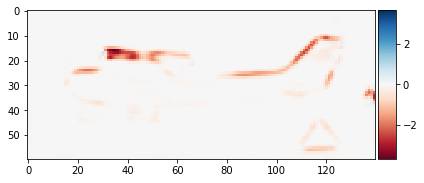

In [312]:
# Harris Corner Representation

def cnr_test(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    cnr_image = corner_harris(img_raw, method='k', k=0.19) # 0.0 < k < 0.2
    #cnr_image = corner_harris(downscaled, method='eps', eps=1.0e-7)

    if imview==True:
        io.imshow(cnr_image)
    warnings.filterwarnings('always')
    return cnr_image

# test the function, look at input/output
test_image = cnr_test('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

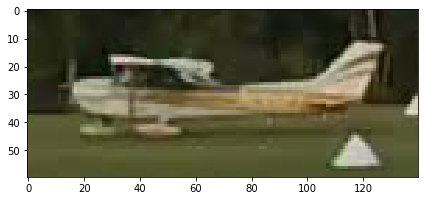

In [313]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

In [314]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(cnr_test(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)

In [315]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=223, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 60, 140)
Shape of flat feature representation: 
(6758, 8400)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
78
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
23
Shape of data_train and data_test:
(5068, 8400)
(1690, 8400)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


In [316]:
# MODEL: Perceptron

# Harris Corner Representation

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc_tr')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'tr'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc_Tr')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'te'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 78, 'Neg': 4990, 'TP': 72, 'TN': 4990, 'FP': 0, 'FN': 6, 'Accuracy': 0.9988161010260458, 'Precision': 1.0, 'Recall': 0.9230769230769231, 'desc': 'prc_tr', 'set': 'tr'}
TEST SET: 
{'Pos': 23, 'Neg': 1667, 'TP': 19, 'TN': 1665, 'FP': 2, 'FN': 4, 'Accuracy': 0.9964497041420118, 'Precision': 0.9047619047619048, 'Recall': 0.8260869565217391, 'desc': 'prc_Tr', 'set': 'te'}


In [317]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')

ValueError: cannot reshape array of size 8400 into shape (15,35)

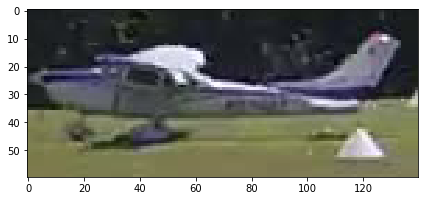

<Figure size 432x288 with 0 Axes>

In [318]:
performance_examples('TP', prc_img_indices_to_view)

In [ ]:
performance_examples('FP', prc_img_indices_to_view)

In [ ]:
performance_examples('FN', prc_img_indices_to_view)

In [319]:
# MODEL: Multi-layer Perceptron aka neural network

# Harris Corner Representation

from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000, hidden_layer_sizes=(200,150,100,50,25))
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_tr')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'tr'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_te')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'te'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(200, 150, 100, 50, 25), max_iter=1000)
TRAINING SET: 
{'Pos': 78, 'Neg': 4990, 'TP': 78, 'TN': 4990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn_tr', 'set': 'tr'}
TEST SET: 
{'Pos': 23, 'Neg': 1667, 'TP': 23, 'TN': 1664, 'FP': 3, 'FN': 0, 'Accuracy': 0.9982248520710059, 'Precision': 0.8846153846153846, 'Recall': 1.0, 'desc': 'nn_te', 'set': 'te'}


In [ ]:
performance_examples('TP', nn_img_indices_to_view)

In [ ]:
performance_examples('FP', nn_img_indices_to_view)

In [ ]:
performance_examples('FN', nn_img_indices_to_view)

In [324]:
# list of fits to compare: 
final_fits = []
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

In [325]:
#matplotlib color codes: b,g,r,c,m,y,k

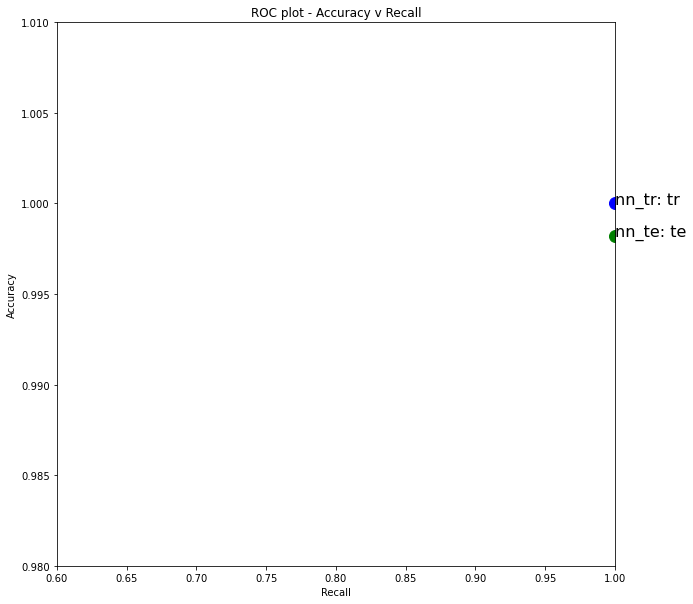

In [326]:
#Plot - Recall v Accuracy

plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] in ['tr']:
        color = 'bo'
    elif fit['set'] in ['te']:
        color = 'go'
    else:
        color = 'ko'
    plt.plot(fit['TP'] / (fit['TP'] + fit['FN']), 
             (fit['TP'] + fit['TN']) / (fit['Pos'] + fit['Neg']), color, markersize=12)
    plt.text(fit['TP'] / (fit['TP'] + fit['FN']), 
             (fit['TP'] + fit['TN']) / (fit['Pos'] + fit['Neg']), fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0.6, 1, 0.98, 1.01])
plt.title('ROC plot - Accuracy v Recall')
plt.xlabel('Recall')
plt.ylabel('Accuracy')
plt.show()

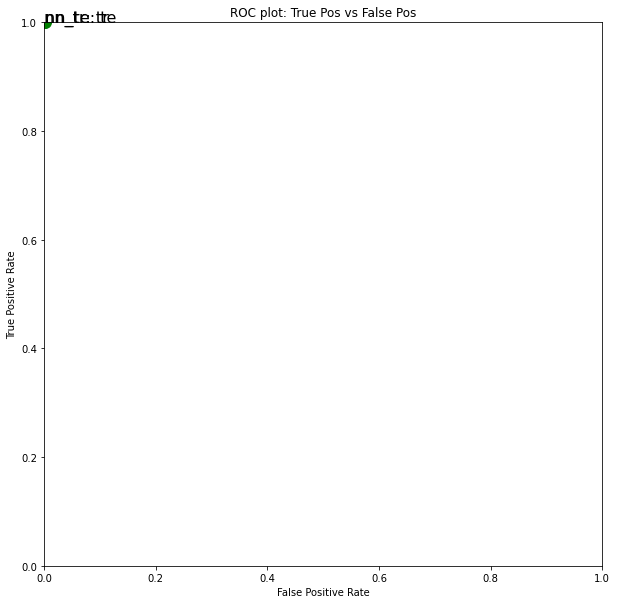

In [327]:
# ROC Plot - True Pos vs False Pos

plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] in ['tr']:
        color = 'bo'
    elif fit['set'] in ['te']:
        color = 'go'
    else:
        color = 'ko'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: True Pos vs False Pos')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [328]:
#SUBMISSION

submission_ci_path = 'C:/Users/geoff/PycharmProjects/machine_learning_assignment2/final_assignment_2/test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'C:/Users/geoff/PycharmProjects/machine_learning_assignment2/final_assignment_2/test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [329]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=223, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 60, 140)
Shape of flat feature representation: 
(1523, 8400)
Shape of X_test for submission:
(1523, 8400)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


In [330]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 8400)
(1523, 8400)


In [331]:
# concatenate predictions to the id
X_test_submission["prediction"] = prc.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.014445173998686802


In [332]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [333]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('C:/Users/geoff/Desktop/New_School/Semester_5/Machine_Learning/assignment2/iterations/airplane_submission_cnr1.csv', index=False)